# NRS - Project Work - Group 1

### Importing Libraries and Data

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

# for sentiment analysis
from textblob import TextBlob

from sklearn.preprocessing import OrdinalEncoder
from sklearn import metrics

from sklearn.metrics import plot_confusion_matrix # plot confusion matrix
from sklearn.model_selection import train_test_split #split train & test
from sklearn.model_selection import GridSearchCV #gridsearch
from sklearn.metrics import classification_report #further metric

missing_values = [''] #define values to be identified as NaN in the datasets 
#,'Undefined', 'Undefined->Undefined'


df_crm = pd.read_csv('crm_model.csv', keep_default_na=False, na_values=missing_values, decimal=',') #import CRM_model
df_finance = pd.read_csv('finance_model.csv', keep_default_na=False, na_values=missing_values, decimal=',') #import finance_model
df_sales = pd.read_csv('sales_model.csv', keep_default_na=False, na_values=missing_values, decimal=',') #import sales_model
#df_twitter_sentiment = pd.read_csv('twitter_azure.csv', keep_default_na=False, na_values=missing_values, decimal=',') #import twitter_azure

<a id="Joining_Datasets"></a>

### Joining Datasets

In [2]:
# column id renaming to join the datasets
df_crm = df_crm.rename(columns={'ID_CRM': 'id'}) 
df_finance = df_finance.rename(columns={'ID_FINANCE': 'id'})
df_sales = df_sales.rename(columns={'ID_SALES': 'id'})
#df_twitter_sentiment = df_twitter_sentiment.rename(columns={'ID_SALES': 'id'})

By observing the structure of each id we find a pattern to extract a common unique id:

<img src="img/ID_schema.png"></img>

In [3]:
# df_crm unique_id extraction
df_crm.id = np.where(df_crm.Income_Level.str.len() == 2,\
                     df_crm.id.str.slice(start = 1, stop = -2),\
                     df_crm.id.str.slice(start = 1, stop = -1))

# df_finance unique_id extraction
df_finance.id = np.where(df_finance.Special_Pay.str.len() == 2,\
                         df_finance.id.str.slice(start = 2),\
                         df_finance.id.str.slice(start = 0))

# df_sales unique_id extraction
df_sales.id = np.where(df_sales.Program_Code.str.len() == 2,\
                       df_sales.id.str.slice(start = 2, stop = -1),\
                       df_sales.id.str.slice(start = 3, stop = -1))

# df_twitter unique_id extraction
# df_twitter_sentiment.id = df_twitter_sentiment.id.str.extract(r'(\d+)', expand=False)

In [4]:
# create a single table to join the datasets
df_merged = df_sales.merge(df_crm, on="id", how="inner").merge(df_finance, on="id", how="inner") #.merge(df_twitter_sentiment, on="id", how="inner")
df_merged.shape

(4148, 54)

### Data preparation

In [127]:
df = df_merged.copy()

In [128]:
def dummification(df):
    
    #_______________ Categorical Dummification
    categorical = df.select_dtypes(exclude=np.number).columns.tolist()
    df = pd.get_dummies(df, columns = categorical, prefix = categorical)
    
    return df

In [129]:
def cleaning_1(df):
    #______________ id
    df.drop(columns=['id'], inplace=True)


    #______________ Program_Code
    #wrong value replaced with na
    df['Program_Code'] = df['Program_Code'].replace({'FN': np.nan})
    #missing values replaced with mode of the parent group
    df['Program_Code'] = df.groupby(['MajorProgramCode'], sort=False)['Program_Code'].apply(lambda x: x.fillna(x.mode().iloc[0]))


    #______________ From_Grade
    #missing values replaced with the median
    df['From_Grade'] = df['From_Grade'].fillna(df['From_Grade'].median())


    #______________ To_Grade
    #missing values replaced with the median (with respect to the subgroup)
    df['To_Grade'] = df.groupby(['From_Grade'], sort=False)['To_Grade'].apply(lambda x: x.fillna(x.median()))
    df['To_Grade'] = df['To_Grade'].fillna(df['To_Grade'].median())


    #____**NEW**____ Delta_From_To_Grade
    #new variable
    df['Delta_From_To_Grade'] = df['To_Grade'] - df['From_Grade']


    #conversion to datetime
    df['Departure_Date'] = pd.to_datetime(df['Departure_Date'])


    #____**NEW**____ Departure_Date_DoY
    #conversion to day of the year
    df['Departure_Date_DoY'] = df['Departure_Date'].dt.dayofyear

    #_______________ Return_Date
    #conversion to datetime
    df['Return_Date'] = pd.to_datetime(df['Return_Date'])


    #____**NEW**____ Return_Date_DoY
    #conversion to day of the year
    df['Return_Date_DoY'] = df['Return_Date'].dt.dayofyear


    #_______________ Early_RPL
    #_______________ Latest_RPL
    #____**NEW**____ RPL_Value
    df['Early_RPL'] = pd.to_datetime(df['Early_RPL'])
    df['Latest_RPL'] = pd.to_datetime(df['Latest_RPL'])

    df['RPL_Value'] = np.where( (df['Early_RPL'].isna()) & (df['Latest_RPL'].isna()), 0, 1)

    df['Early_RPL'].fillna(df['Latest_RPL'].mode()[0], inplace=True)
    df['Latest_RPL'].fillna(df['Latest_RPL'].mode()[0], inplace=True)

    temp_min = df[['Early_RPL','Latest_RPL']].min(axis=1)
    temp_max = df[['Early_RPL','Latest_RPL']].max(axis=1)

    df['Early_RPL'] = temp_min
    df['Latest_RPL'] = temp_max


    #____**NEW**____ Early_RPL_DoY
    #____**NEW**____ Latest_RPL_DoY
    df['first_january'] = pd.to_datetime('1/1/' + str(df['Departure_Date'].dt.year[0]))
    df['Early_RPL_DoY'] = df['Early_RPL'] - df['first_january']
    df['Early_RPL_DoY'] = df['Early_RPL_DoY'].astype('timedelta64[D]').astype(int)
    df['Latest_RPL_DoY'] = df['Latest_RPL'] - df['first_january']
    df['Latest_RPL_DoY'] = df['Latest_RPL_DoY'].astype('timedelta64[D]').astype(int)


    #_______________ Initial_System_Date
    df['Initial_System_Date'] = pd.to_datetime(df['Initial_System_Date'])
    df['Initial_System_Date'].fillna(df['Initial_System_Date'].mode()[0], inplace=True)


    #____**NEW**____ Initial_System_Date_DoY
    df['Initial_System_Date_DoY'] = df['Initial_System_Date'] - df['first_january']
    df['Initial_System_Date_DoY'] = df['Initial_System_Date_DoY'].astype('timedelta64[D]').astype(int)


    #______________ DepartureMonth
    df.drop(columns=['DepartureMonth'], inplace=True)


    #_______________ GroupGradeTypeLow
    df['GroupGradeTypeLow'] = df['GroupGradeTypeLow'].fillna(df['GroupGradeTypeLow'].mode()[0])


    #_______________ GroupGradeTypeHigh
    df['GroupGradeTypeHigh'] = df.groupby(['GroupGradeTypeLow'], sort=False)['GroupGradeTypeHigh'].apply(lambda x: x.fillna(x.mode()[0]))
    df['GroupGradeTypeHigh'] = df['GroupGradeTypeHigh'].fillna(df['GroupGradeTypeHigh'].mode()[0])


    #_______________ GroupGradeType
    df['GroupGradeType'] = df['GroupGradeTypeLow'] + '->' + df['GroupGradeTypeHigh']


    #_______________ CRM_Segment
    df['CRM_Segment'].fillna(df['CRM_Segment'].mode()[0], inplace=True)


    #_______________ MDR_Low_Grade
    #_______________ MDR_High_Grade
    df['MDR_Low_Grade'].replace({'0': df['MDR_Low_Grade'].mode()[0]}, inplace=True)
    df['MDR_High_Grade'].replace({'NA': df['MDR_High_Grade'].mode()[0]}, inplace=True)


    #_______________ Total_School_Enrollment
    df['Total_School_Enrollment'] = df['Total_School_Enrollment'].replace({0: np.nan})
    df['Total_School_Enrollment'] = df['Total_School_Enrollment'].fillna(df['Total_School_Enrollment'].mean())


    #_______________ FPP_to_School_enrollment
    df['FPP_to_School_enrollment'] = df['FPP_to_School_enrollment'].fillna(df['FPP_to_School_enrollment'].mean())


    #____**NEW**____ FPP_to_School_enrollment_rev
    df['FPP_to_School_enrollment_rev'] = df['FPP'] / df['Total_School_Enrollment']


    #_______________ Poverty_Code
    df['Poverty_Code'] = df['Poverty_Code'].replace({'0': 'E'})


    #_______________ Income_Level
    df['Poverty_Code'] = df['Poverty_Code'].replace({'0': 'Z'})


    #_______________ FirstMeeting
    df['FirstMeeting'] = pd.to_datetime(df['FirstMeeting'])
    df['FirstMeeting'].fillna(df['FirstMeeting'].mode()[0], inplace=True)


    #____**NEW**____ FirstMeeting_DoY
    df['FirstMeeting_DoY'] = df['FirstMeeting'] - df['first_january']
    df['FirstMeeting_DoY'] = df['FirstMeeting_DoY'].astype('timedelta64[D]').astype(int)


    #_______________ LastMeeting
    df['LastMeeting'] = pd.to_datetime(df['LastMeeting'])
    df['LastMeeting'].fillna(df['LastMeeting'].mode()[0], inplace=True)


    #____**NEW**____ LastMeeting_DoY
    df['LastMeeting_DoY'] = df['LastMeeting'] - df['first_january']
    df['LastMeeting_DoY'] = df['LastMeeting_DoY'].astype('timedelta64[D]').astype(int)


    #_______________ DifferenceTraveltoFirstMeeting
    df['DifferenceTraveltoFirstMeeting'] = df['Departure_Date_DoY'] - df['FirstMeeting_DoY']


    #_______________ DifferenceTraveltoLastMeeting
    df['DifferenceTraveltoLastMeeting'] = df['Departure_Date_DoY'] - df['LastMeeting_DoY']


    #_______________ SchoolSizeIndicator
    df['SchoolSizeIndicator'].fillna(df['SchoolSizeIndicator'].mode()[0], inplace=True)


    #_______________ Deposit_Date
    df['Deposit_Date'] = pd.to_datetime(df['Deposit_Date'])


    #____**NEW**____ Deposit_Date_DoY
    df['Deposit_Date_DoY'] = df['Deposit_Date'] - df['first_january']
    df['Deposit_Date_DoY'] = df['Deposit_Date_DoY'].astype('timedelta64[D]').astype(int)


    #_______________ Special_Pay
    df['Special_Pay'] = df['Special_Pay'].replace({'0': df['Special_Pay'].mode()[0]})


    #_______________ Drop Columns
    df.drop(columns=['first_january'], inplace=True)
    df.drop(columns=['Departure_Date', 'Return_Date', 'Early_RPL', 'Latest_RPL', 'FirstMeeting', 'LastMeeting', 'Initial_System_Date', 'Deposit_Date'], inplace=True)

In [130]:
cleaning_1(df)

### Data exploration

In [41]:
#df.to_excel("clean.xlsx")

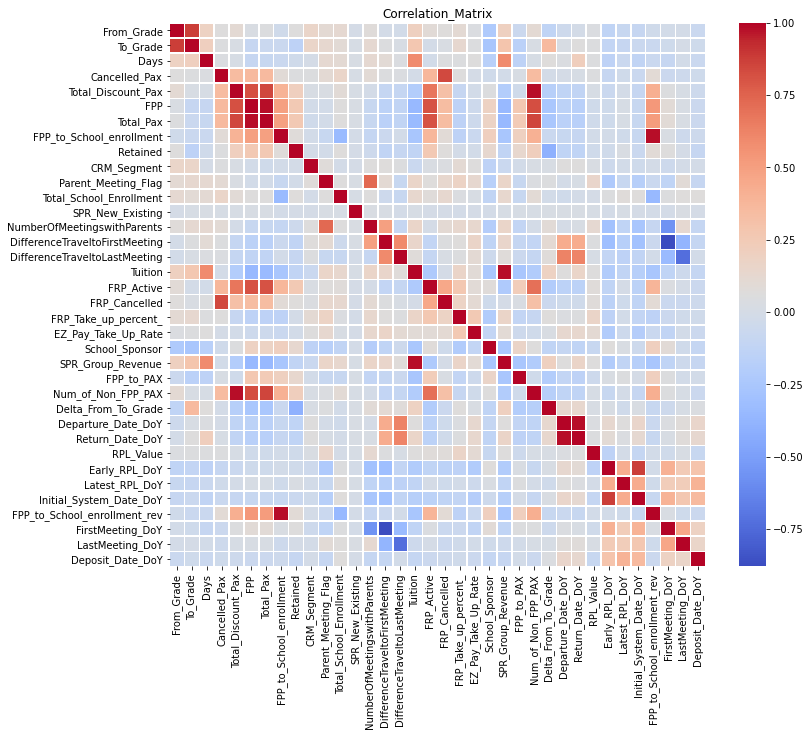

In [135]:
Numerical = df.select_dtypes(include=np.number).columns.tolist()
data_to_heatmap = df[Numerical]


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


plt.figure(figsize = (12,10))
sns.heatmap(data=data_to_heatmap.corr().round(2), cmap='coolwarm', linewidths=.5, annot=False, annot_kws={"size":10}).set_title('Correlation_Matrix')
plt.show()

<AxesSubplot:>

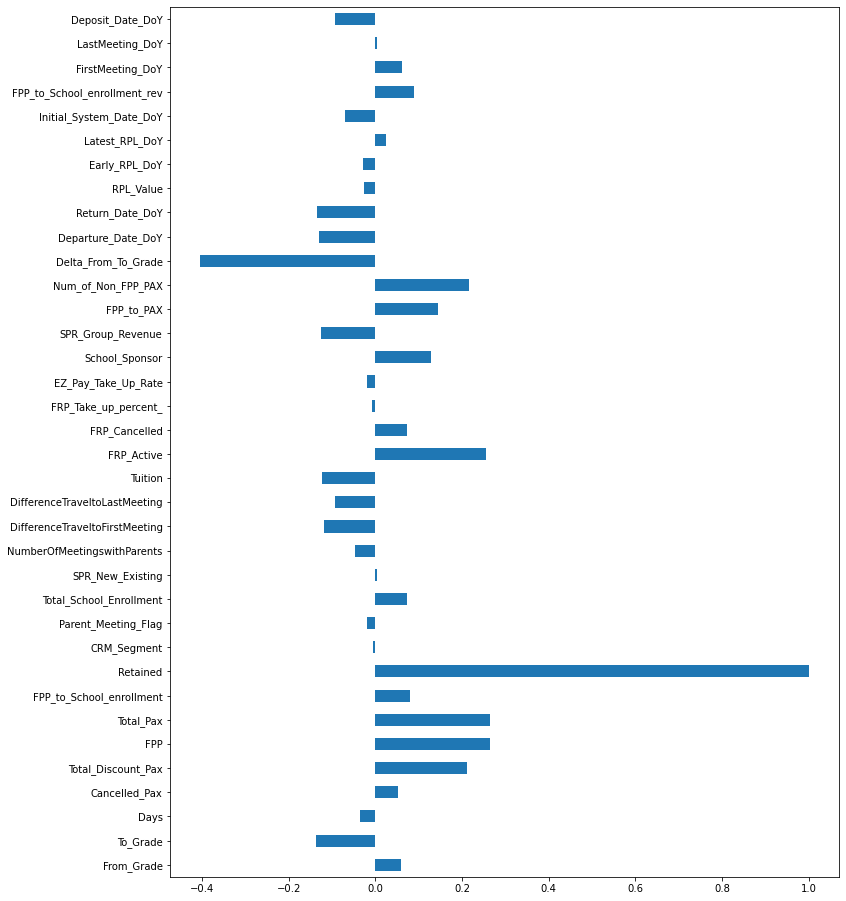

In [142]:
plt.figure(figsize = (12,16))
data_to_heatmap[data_to_heatmap.columns[:]].corr()['Retained'][:].plot(kind='barh')

In [ ]:
df = dummification(df)

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4148 entries, 0 to 4147
Columns: 239 entries, From_Grade to Special_Pay_SA
dtypes: float64(10), int32(7), int64(19), uint8(203)
memory usage: 2.0 MB


## Models

In [105]:
X = df.drop(columns=['Retained'])
y = df['Retained']

In [106]:
#SPLIT DATA INTO TRAIN AND TEST SET
X_train, X_test, y_train, y_test = train_test_split(X, y,  #X_scaled
                                                    test_size =0.30, #by default is 75%-25%
                                                    #shuffle is set True by default,
                                                    stratify=y,
                                                    random_state= 123) #fix random seed for replicability

print(X_train.shape)
print(X_test.shape)

(2903, 238)
(1245, 238)


### Classification Tree

In [107]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_split=4, min_samples_leaf=2)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [108]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

[[322 167]
 [145 611]]


In [109]:
#DEFINE YOUR CLASSIFIER and THE PARAMETERS GRID
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier()
parameters = {'criterion': ['entropy','gini'], 
              'max_depth': [3,4,5,10],
              'min_samples_split': [5,10,3],
              'min_samples_leaf': [2,1]}

In [110]:
#DEFINE YOUR GRIDSEARCH 
'''
GS perfoms an exhaustive search over specified parameter values for an estimator.
GS uses a Stratified K-Folds cross-validator
(The folds are made by preserving the percentage of samples for each class.)
If refit=True the model is retrained on the whole training set with the best found params
'''
gs = GridSearchCV(classifier, parameters, cv=3, scoring = 'f1', verbose=10, n_jobs=-1, refit=True)

In [111]:
#TRAIN YOUR CLASSIFIER
gs = gs.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0817s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:    1.8s finished


In [112]:
#summarize the results of your GRIDSEARCH
print('***GRIDSEARCH RESULTS***')

print("Best score: %f using %s" % (gs.best_score_, gs.best_params_))
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
params = gs.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

***GRIDSEARCH RESULTS***
Best score: 0.805725 using {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 3}
0.789783 (0.006848) with: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5}
0.789783 (0.006848) with: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 10}
0.789783 (0.006848) with: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 3}
0.789783 (0.006848) with: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5}
0.789783 (0.006848) with: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10}
0.789783 (0.006848) with: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 3}
0.787139 (0.001435) with: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 5}
0.787139 (0.001435) with: {'criterion': 'entropy', 'max_depth'

In [113]:
#TEST ON YOUR TEST SET 
best_model = gs.best_estimator_
y_pred = best_model.predict(X_test)

#EVALUATE YOUR PREDICTION (on the y_test that you left aside)
print('***RESULTS ON TEST SET***')
print("f1_score: ", metrics.f1_score(y_test, y_pred))

***RESULTS ON TEST SET***
f1_score:  0.8104918032786885


In [114]:
#TEST ON YOUR TRAIN SET 
best_model = gs.best_estimator_
y_pred_train = best_model.predict(X_train)

#EVALUATE YOUR PREDICTION (on the y_trai
print('***RESULTS ON TRAIN SET***')
print("f1_score: ", metrics.f1_score(y_train, y_pred_train))

***RESULTS ON TRAIN SET***
f1_score:  0.9211267605633803


In [115]:
#PRINT SOME FURTHER METRICS
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.69      0.70       489
           1       0.80      0.82      0.81       756

    accuracy                           0.77      1245
   macro avg       0.76      0.75      0.76      1245
weighted avg       0.77      0.77      0.77      1245



Confusion matrix, without normalization
[[338 151]
 [138 618]]
Normalized confusion matrix
[[0.69120654 0.30879346]
 [0.18253968 0.81746032]]


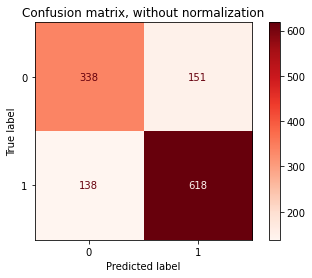

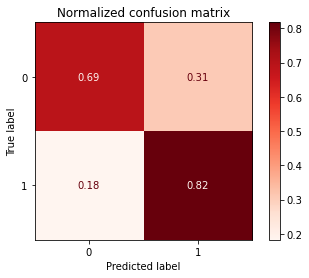

In [116]:
# Plot confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(best_model, X_test, y_test,
                                 #display_labels=class_names,
                                 cmap=plt.cm.Reds,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

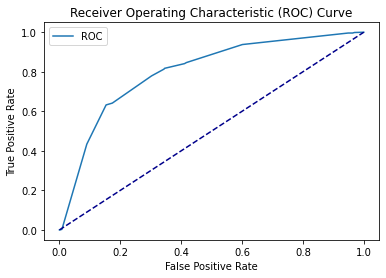

AUC: 0.80


In [117]:
model = DecisionTreeClassifier(criterion='gini', max_depth=4, min_samples_leaf=2, min_samples_split=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

y_probs = model.predict_proba(X_test) #predict_proba gives the probabilities for the target (0 and 1 in your case) 

fpr, tpr, thresholds=metrics.roc_curve(y_test,  y_probs[:,1])

import matplotlib.pyplot as plt
plt.plot(fpr, tpr, label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

auc = metrics.roc_auc_score(y_test, y_probs[:,1])
print('AUC: %.2f' % auc)

In [118]:
from sklearn import tree
r = tree.export_text(model,feature_names=X_test.columns.tolist())
print(r)

|--- Delta_From_To_Grade <= 0.50
|   |--- Total_Pax <= 16.50
|   |   |--- SchoolGradeTypeLow_Undefined <= 0.50
|   |   |   |--- FPP_to_School_enrollment_rev <= 0.00
|   |   |   |   |--- class: 0
|   |   |   |--- FPP_to_School_enrollment_rev >  0.00
|   |   |   |   |--- class: 1
|   |   |--- SchoolGradeTypeLow_Undefined >  0.50
|   |   |   |--- Latest_RPL_DoY <= -105.00
|   |   |   |   |--- class: 0
|   |   |   |--- Latest_RPL_DoY >  -105.00
|   |   |   |   |--- class: 0
|   |--- Total_Pax >  16.50
|   |   |--- FRP_Active <= 15.50
|   |   |   |--- Deposit_Date_DoY <= -42.50
|   |   |   |   |--- class: 1
|   |   |   |--- Deposit_Date_DoY >  -42.50
|   |   |   |   |--- class: 1
|   |   |--- FRP_Active >  15.50
|   |   |   |--- Group_State_SC <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- Group_State_SC >  0.50
|   |   |   |   |--- class: 0
|--- Delta_From_To_Grade >  0.50
|   |--- GroupGradeType_Middle->Middle <= 0.50
|   |   |--- Total_School_Enrollment <= 702.00
|   |   |   |---

### Random Forest

In [119]:
from sklearn.ensemble import RandomForestClassifier

rand_forest = RandomForestClassifier(n_estimators=30, criterion='entropy', max_depth=6, min_samples_split=4, min_samples_leaf=2)
rand_forest.fit(X_train, y_train)

y_pred = rand_forest.predict(X_test)

In [120]:
#TEST ON YOUR TEST SET 
y_pred = rand_forest.predict(X_test)

#EVALUATE YOUR PREDICTION (on the y_test that you left aside)
print('***RESULTS ON TEST SET***')
print("f1_score: ", metrics.f1_score(y_test, y_pred))

***RESULTS ON TEST SET***
f1_score:  0.8031496062992126


In [121]:
#TEST ON YOUR TRAIN SET 
y_pred_train = rand_forest.predict(X_train)

#EVALUATE YOUR PREDICTION (on the y_train)
print('***RESULTS ON TRAIN SET***')
print("f1_score: ", metrics.f1_score(y_train, y_pred_train))

***RESULTS ON TRAIN SET***
f1_score:  0.8392810627767648


In [122]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.53      0.61       489
           1       0.74      0.88      0.80       756

    accuracy                           0.74      1245
   macro avg       0.74      0.70      0.71      1245
weighted avg       0.74      0.74      0.73      1245



Confusion matrix, without normalization
[[338 151]
 [138 618]]
Normalized confusion matrix
[[0.69120654 0.30879346]
 [0.18253968 0.81746032]]


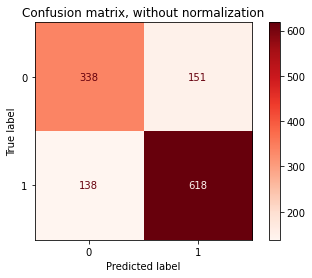

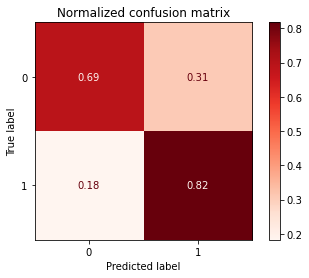

In [123]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(best_model, X_test, y_test,
                                 #display_labels=class_names,
                                 cmap=plt.cm.Reds,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

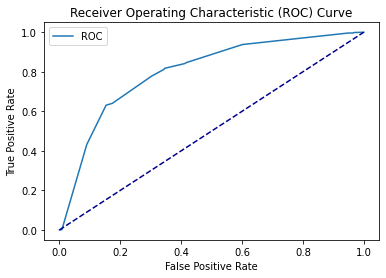

AUC: 0.80


In [124]:
model = DecisionTreeClassifier(criterion='gini', max_depth=4, min_samples_leaf=2, min_samples_split=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

y_probs = model.predict_proba(X_test) #predict_proba gives the probabilities for the target (0 and 1 in your case) 

fpr, tpr, thresholds=metrics.roc_curve(y_test,  y_probs[:,1])

import matplotlib.pyplot as plt
plt.plot(fpr, tpr, label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

auc = metrics.roc_auc_score(y_test, y_probs[:,1])
print('AUC: %.2f' % auc)

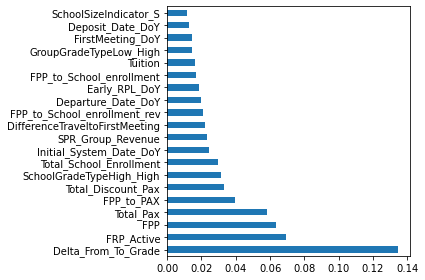

In [125]:
# FEATURE IMPORTANCE:

feat_importances = dict(zip(X_train.columns, rand_forest))
feat_importances = pd.Series(rand_forest.feature_importances_, index=X_train.columns)
feat_importances = feat_importances.sort_values(ascending=False)
x = feat_importances.nlargest(20)
x.plot(kind='barh')
plt.gcf().subplots_adjust(bottom=0.15)
plt.tight_layout()


feat_importances=feat_importances.reset_index()
feat_importances=feat_importances.rename(columns={'index':'features', 0:'importance'})

### Adaboost

In [31]:
from sklearn.ensemble import AdaBoostClassifier

adaboost = AdaBoostClassifier(n_estimators=1000, base_estimator=DecisionTreeClassifier(max_depth=10))
adaboost.fit(X_train, y_train)

y_pred = adaboost.predict(X_test)

y_pred_train = adaboost.predict(X_train)
print("f1_score: ", metrics.f1_score(y_test, y_pred))

f1_score:  0.8960709759188847


In [32]:
classifier= AdaBoostClassifier()
parameters = {'n_estimators' : [100, 500, 1000, 2000],
    'learning_rate' : [0.0001, 0.01, 0.1, 1.0]}

gs = GridSearchCV(classifier, parameters, cv=3, scoring = 'f1', verbose=10, n_jobs=-1, refit=True)

gs.fit(X_train,y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   49.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  38 out of  48 | elapsed:  1.7min remaining:   27.0s
[Parallel(n_jobs=-1)]: Done  43 out of  48 | elapsed:  2.1min remaining:   14.3s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  2.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  2.4min finished


GridSearchCV(cv=3, estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.0001, 0.01, 0.1, 1.0],
                         'n_estimators': [100, 500, 1000, 2000]},
             scoring='f1', verbose=10)

In [157]:
#summarize the results of your GRIDSEARCH
print('***GRIDSEARCH RESULTS***')

print("Best score: %f using %s" % (gs.best_score_, gs.best_params_))
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
params = gs.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

***GRIDSEARCH RESULTS***
Best score: 0.804802 using {'learning_rate': 0.1, 'n_estimators': 1000}
0.786269 (0.006725) with: {'learning_rate': 0.0001, 'n_estimators': 100}
0.786269 (0.006725) with: {'learning_rate': 0.0001, 'n_estimators': 500}
0.786269 (0.006725) with: {'learning_rate': 0.0001, 'n_estimators': 1000}
0.786269 (0.006725) with: {'learning_rate': 0.0001, 'n_estimators': 2000}
0.786269 (0.006725) with: {'learning_rate': 0.01, 'n_estimators': 100}
0.788023 (0.008970) with: {'learning_rate': 0.01, 'n_estimators': 500}
0.794974 (0.007842) with: {'learning_rate': 0.01, 'n_estimators': 1000}
0.796025 (0.009968) with: {'learning_rate': 0.01, 'n_estimators': 2000}
0.794551 (0.008895) with: {'learning_rate': 0.1, 'n_estimators': 100}
0.801192 (0.006179) with: {'learning_rate': 0.1, 'n_estimators': 500}
0.804802 (0.004396) with: {'learning_rate': 0.1, 'n_estimators': 1000}
0.800273 (0.007253) with: {'learning_rate': 0.1, 'n_estimators': 2000}
0.792867 (0.008449) with: {'learning_rate

In [158]:
#TEST ON YOUR TEST SET 
best_model = gs.best_estimator_
y_pred = best_model.predict(X_test)

Confusion matrix, without normalization
[[327 162]
 [124 632]]
Normalized confusion matrix
[[0.66871166 0.33128834]
 [0.16402116 0.83597884]]


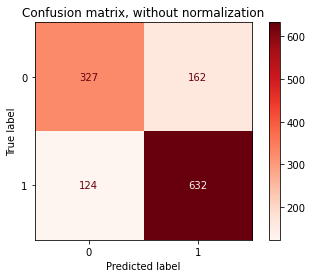

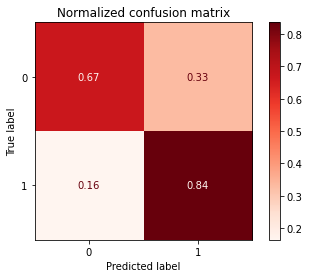

In [159]:
# Plot confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(best_model, X_test, y_test,
                                 #display_labels=class_names,
                                 cmap=plt.cm.Reds,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [160]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.67      0.70       489
           1       0.80      0.84      0.82       756

    accuracy                           0.77      1245
   macro avg       0.76      0.75      0.76      1245
weighted avg       0.77      0.77      0.77      1245



In [161]:
y_pred_train = adaboost.predict(X_train)
print("f1_score: ", metrics.f1_score(y_train, y_pred_train))

f1_score:  1.0


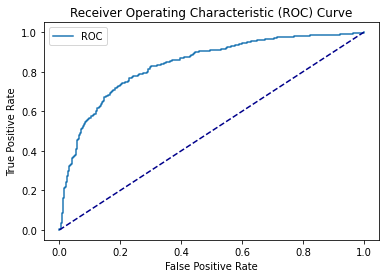

AUC: 0.84


In [162]:
adaboost = AdaBoostClassifier(n_estimators=2000, learning_rate=0.1)

adaboost.fit(X_train,y_train)

y_probs = adaboost.predict_proba(X_test) #predict_proba gives the probabilities for the target (0 and 1 in your case) 

fpr, tpr, thresholds=metrics.roc_curve(y_test,  y_probs[:,1])

import matplotlib.pyplot as plt
plt.plot(fpr, tpr, label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

auc = metrics.roc_auc_score(y_test, y_probs[:,1])
print('AUC: %.2f' % auc)